# Assignment 1
In the following tasks of this exercise sheet we consider two humanoid robots, **H1** and **H2**, working in a household environment. H1 is equipped with a time-of-flight camera **C1** with a resolution of **640x480** pixels. In comparison, H2 uses a **1920x1080** pixel stereo camera **C2** to perceive the world.  Both cameras are mounted on the heads of the humanoids and are intrinsically and extrinsically calibrated.

1. **Homogenous Coordinates**

   a. Explain why Homogenous coordinates are beneficial compared to using  separate Euclidean rotation and translation matrices.

      Homogenous coordinates simplify the mathematical calculations required when doing rotations and translations. This is because it allows to represent them as matrices to multiply the vector, this way, any kind of combination of translations and rotations are easily calculated and represented by one matrix, which could not be achieved using Euclidean coordinates. This option makes the usage of Homogenous coordinates more convenient, as it is less expensive, especially when there is multiple transformations needed as is the case with multiple origin points.

      A matrix can be represented like this:

      $$ H = \begin{bmatrix} R & t \\ 0^T & 1 \end{bmatrix} $$

      Where R represents the rotation and t the translation.

   b. Discuss the specific implications this has for simplifying the process of chaining multiple transformations and inverting them, which are common requirements in robotic perception and control.
   
     As explained above, Homogenous transformations can be expressed as a matrix, whereas in Euclidean coordinates it is not quite possible. By having a matrix representing the transformation, processess such as chaining transformations or inverting them gets much easier, as it is only needed to do some basic matrix calculations such as multiplication or inversion respectively. That way, the process to get from one origin to another, passing through many different other origin points gets easier by just multiplying the matrices, and getting the data point from before a transformation is easily done by just multiplying the inverse. It is important to notice that chaining transformations is not commutative, because the order of the origins is important.

     The following equations represent inverting a transformation:

     $$ X' = HX $$
     $$ X = H^{-1}X'$$

     Meanwhile the following represents chaining transformations (which is not commutative):

     $$X' = H_1H_2X$$
     $$   \neq H_2H_1X$$

2. **Calibration**
   a. In order to extend its application range, we decided to use H1 outdoors as well. However, due to the higher complexity of this domain, it was decided to replace its current camera with C2 in order to benefit from its higher camera resolution. Therefore, the two cameras need to be swapped. What kind of calibration should be done? **Justify your answer**.
   
   > Intrinsic calibration needs to be done. C2 is a completely different camera with different optics, sensor resolution (1920x1080 vs 640x480), and potentially different lens distortions and focal lengths than C1. Therefore, its intrinsic parameters, such as focal length, principal point, and distortion coefficients, are different and must be recalibrated. Assuming the 2 cameras don't differ in size and C2 is mounted perfectly identical to how C1 was, no extrinsic calibration is needed. Otherwise, we need to do extrinsic calibration for C2 as well, because the camera frame would be different.

   b. As H1 was walking outside, he accidentally hit his head on a high hanging pole and the camera got dislodged. Fortunately, C2 suffered no external damage and was put back in place. What kind of calibration should be done in this case? **Justify your answer**.
   
   > Only extrinsic calibration needs to be redone. The camera itself (C2) has not changed, so its intrinsic parameters remain valid. However, the camera was physically moved and then repositioned. Its orientation and position with respect to H1’s frame of reference may have changed even slightly, which affects how the robot interprets spatial information. Hence, a new extrinsic calibration is necessary to ensure accurate environmental mapping and perception.


3. **Pinhole Projection**

a.	Write a function to derive the intrinsic matrix given the camera constant, principal point and pixel scaling factors.  **Print the resulting matrix**.

b.	Implement a function that takes as input 3D points in Euclidean coordinates, converts them to Homogenous coordinates and outputs their corresponding 2D image coordinates. **Visualize the 2D image coordinates on a scatter plot.**

[[800.   0. 320.]
 [  0. 800. 240.]
 [  0.   0.   1.]]
[[320. 240.]
 [480. 400.]
 [160. 400.]
 [480.  80.]
 [160.  80.]]


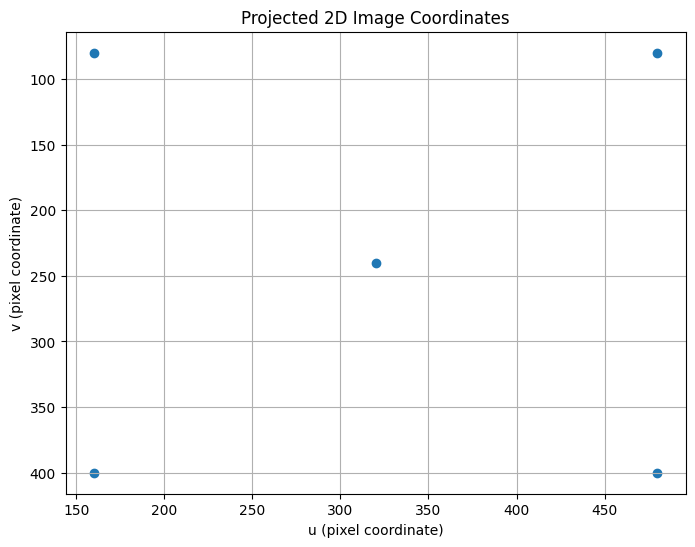

In [145]:
import numpy as np
import matplotlib.pyplot as plt

def build_intrinsic_matrix(f, s_x, s_y, c_x, c_y):
    """
    Construct the intrinsic matrix K for the pinhole camera model.

    :return: 3x3 intrinsic matrix K
    """
    # TODO: Implement the intrinsic matrix
    K = np.array([[f/s_x, 0, c_x],
                  [0, f/s_y, c_y],
                  [0, 0, 1]])
    return K
    #pass

def project_points(points_3d, K):
    """
    Projects 3D points in the camera frame (in homogeneous coordinates) to 2D image coordinates using the intrinsic matrix K.
    :param points_3d: points in Euclidean coordinates
    :param K: intrinsic matrix
    :return points_2d: projected 2D points
    """
    # TODO: Implement the projection
    #Convert 3D points to homogeneous coordinates or camera frame
    homogeneous_3d_coordinates = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    transpose_hom_3d_co = homogeneous_3d_coordinates.T
    #Get 2d image coordinates using intrinsic matrix K
    homogeneous_2d_image_coordinates = K @ transpose_hom_3d_co[:3, :]
    euclidean_2d_image_coordinates = (homogeneous_2d_image_coordinates[:2, :] / homogeneous_2d_image_coordinates[2, :]).T
    return euclidean_2d_image_coordinates
    #pass

# Example usage:
# Define intrinsic parameters
f = 800
c_x, c_y = 320, 240
s_x = s_y = 1

# 3D points (in homogeneous coordinates)
# Format: [x, y, z]
points = np.array([
    [0, 0, 5],
    [1, 1, 5],
    [-1, 1, 5],
    [1, -1, 5],
    [-1, -1, 5]
])


# Print the K matrix
K = build_intrinsic_matrix(f, s_x, s_y, c_x, c_y)
print(K)
# Print the 2D image coordinates
image_2d_coordinates = project_points(points, K)
print(image_2d_coordinates)

#Visualization
plt.figure(figsize=(8, 6))
plt.scatter(image_2d_coordinates[:, 0], image_2d_coordinates[:, 1])
plt.xlabel("u (pixel coordinate)")
plt.ylabel("v (pixel coordinate)")
plt.title("Projected 2D Image Coordinates")
plt.grid(True)
plt.gca().invert_yaxis()  # y-axis points downwards in image coordinate systems
plt.show()

4.	**Intrinsic Parameter Estimation Using World-to-Camera Transformations**

Suppose H1 is positioned so that its torso is positioned at (2, 3, 1) in the world coordinate system, with the torso's axes aligned with the world axes. Unfortunately, C2 has to be replaced by another camera that can provide better depth estimates. We assume that the transformation between the torso frame and the camera frame is known due to the fixed location of the 3D printed camera mount. In particular, the camera is mounted 1 meter above the torso. In the torso frame, the camera's position is (0, 0, 1), and its coordinate system is rotated relative to the torso frame so that the camera's x-axis remains aligned with the torso's x-axis, the camera's y-axis points downward (opposite the torso's z-axis), and the camera's z-axis (pointing forward) is parallel to the torso's y-axis (i.e., horizontal with respect to the ground).

a. Plot a visualization of the three coordinate systems (world, torso, camera) at the current locations

b. Write a function to transform 3D points provided in the world coordinate system into the camera frame using homogeneous coordinates. Transform the points provided in 4b_3d_world_points.csv to camera coordinates and print them

Assume that the 3D points in the world frame are projected onto the image plane via a pinhole camera model using the intrinsic matrix given in the slides. The corresponding projected points have been estimated using a calibration procedure. Assume that there is no scale difference in x and y. Estimate the intrinsic parameters under the following conditions:

c. The 2D projections are noiseless. Use the csv files 4c_3d_noiseless_world_points.csv and 4c_noiseless_image_coordinates.csv

d. The 2D projections contain noise, and the number of correspondences exceeds the number of unknown parameters. Use the csv files 4c_3d_noisy_world_points.csv and 4d_noisy_image_coordinates.csv


In [146]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [147]:
# load the dataset here
df = pd.read_csv('4b_world_points.csv')

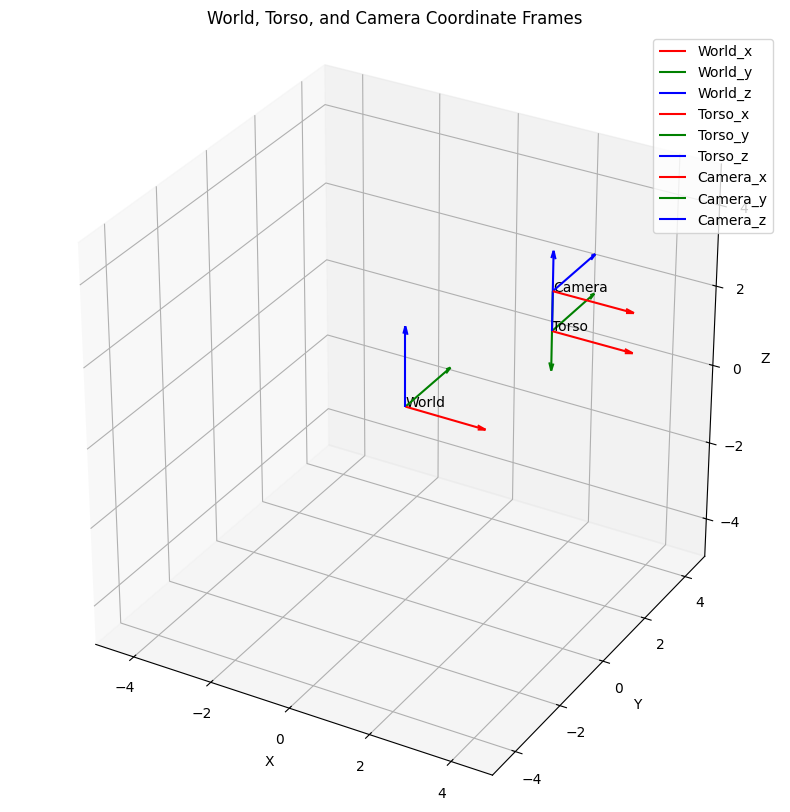

In [148]:
# 4.a
def get_torso2world_transform():
    # return the torso coordinate frame in world coordinates using Homogenous transforms:
    """
    Returns the homogeneous transformation matrix representing the torso frame in world coordinates.
    """
    # Torso is at (2, 3, 1) in world frame, with axes aligned.
    transform = np.array([
        [1, 0, 0, 2],
        [0, 1, 0, 3],
        [0, 0, 1, 1],
        [0, 0, 0, 1]
    ])
    return transform
    #pass

def get_camera2torso_transform():
    # return the camera coordinate frame in torso coordinates using Homogenous transforms:
    """
    Returns the homogeneous transformation matrix representing the camera frame in torso coordinates.
    """
    # Camera is at (0, 0, 1) in torso frame.
    translation = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 1],
        [0, 0, 0, 1]
    ])

    # Rotation: camera x = torso x, camera y = -torso z, camera z = torso y
    rotation = np.array([
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, -1, 0, 0],
        [0, 0, 0, 1]
    ])

    transform = np.dot(translation, rotation)
    return transform

    #pass

def get_camera2world_transform():
    # using above two functions return camera coordinate frame in world coordinates
    """
    Returns the homogeneous transformation matrix representing the camera frame in world coordinates
    using the above two functions.
    """
    torso2world = get_torso2world_transform()
    camera2torso = get_camera2torso_transform()
    camera2world = np.dot(torso2world, camera2torso)
    return camera2world
    #pass

def plot_coordinate_frame(ax, transform, label, color_x='r', color_y='g', color_z='b', length=1):
    #Plots a coordinate frame given its homogeneous transformation matrix.
    origin = transform[:3, 3]
    x_axis = transform[:3, 0]
    y_axis = transform[:3, 1]
    z_axis = transform[:3, 2]

    ax.quiver(origin[0], origin[1], origin[2], x_axis[0] * length, x_axis[1] * length, x_axis[2] * length, color=color_x, arrow_length_ratio=0.1, label=f'{label}_x')
    ax.quiver(origin[0], origin[1], origin[2], y_axis[0] * length, y_axis[1] * length, y_axis[2] * length, color=color_y, arrow_length_ratio=0.1, label=f'{label}_y')
    ax.quiver(origin[0], origin[1], origin[2], z_axis[0] * length, z_axis[1] * length, z_axis[2] * length, color=color_z, arrow_length_ratio=0.1, label=f'{label}_z')
    ax.text(origin[0], origin[1], origin[2], label)

def plot_coordinate_frames():
    # plot the three coordinate frames with x shown in red, y shown in green and z in blue. The frame should form a right-handed coordinate system
    """
    Plots the world, torso, and camera coordinate frames.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('equal')

    # World frame (identity transformation)
    world_transform = np.eye(4)
    plot_coordinate_frame(ax, world_transform, 'World', length=2)

    # Torso frame
    torso_transform = get_torso2world_transform()
    plot_coordinate_frame(ax, torso_transform, 'Torso', color_x='r', color_y='g', color_z='b', length=2)

    # Camera frame
    camera_transform = get_camera2world_transform()
    plot_coordinate_frame(ax, camera_transform, 'Camera', color_x='r', color_y='g', color_z='b', length=2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('World, Torso, and Camera Coordinate Frames')
    ax.legend()

    # Set reasonable limits for the plot
    max_val = 5
    ax.set_xlim([-max_val, max_val])
    ax.set_ylim([-max_val, max_val])
    ax.set_zlim([-max_val, max_val])

    plt.show()
plot_coordinate_frames()

In [149]:
# 4.b
def world_to_camera(world_point):
    # Get the transformation matrix from world to camera
    camera2world_transform = get_camera2world_transform()
    world2camera_transform = np.linalg.inv(camera2world_transform)

    # Convert the world point to homogeneous coordinates
    world_point_homogeneous = np.array([world_point[0], world_point[1], world_point[2], 1])

    # Transform the point to the camera frame
    camera_point_homogeneous = np.dot(world2camera_transform, world_point_homogeneous)

    # Convert back to Cartesian coordinates
    camera_point = camera_point_homogeneous[:3] / camera_point_homogeneous[3]

    return camera_point

def transform_3d_points_world_to_3d_points_cam(points_3d_world):
    # Use the transforms from 4.a to convert the 3d points in the world coordinate system to camera coordinate system
    for index, row in points_3d_world.iterrows():
        world_point = [row['X_world'], row[' Y_world'], row[' Z_world']]
        camera_point = world_to_camera(world_point)
        print(f"World Point: {world_point} -> Camera Point: {camera_point}")
    #pass
transform_3d_points_world_to_3d_points_cam(df)

World Point: [np.float64(1.7490802376947248), np.float64(9.391963650868428), np.float64(1.0985713871801677)] -> Camera Point: [-0.25091976  0.90142861  6.39196365]
World Point: [np.float64(2.1973169683940728), np.float64(5.935967122017216), np.float64(2.687962719115127)] -> Camera Point: [ 0.19731697 -0.68796272  2.93596712]
World Point: [np.float64(1.1161672243363987), np.float64(8.606690070459253), np.float64(1.2676477084501296)] -> Camera Point: [-0.88383278  0.73235229  5.60669007]
World Point: [np.float64(2.416145155592091), np.float64(10.819459112971966), np.float64(2.958831011408395)] -> Camera Point: [ 0.41614516 -0.95883101  7.81945911]
World Point: [np.float64(2.6648852816008435), np.float64(6.090949803242603), np.float64(2.575321778643448)] -> Camera Point: [ 0.66488528 -0.57532178  3.0909498 ]
World Point: [np.float64(1.3668090197068676), np.float64(8.148538589793427), np.float64(2.3915155140809246)] -> Camera Point: [-0.63319098 -0.39151551  5.14853859]
World Point: [np.fl

In [150]:
# 4.c
def estimate_intrinsic_matrix_noiseless(world_points, image_points):
    # Read the  4c_3d_noiseless_world_points.csv and 4c_noiseless_image_coordinates.csv. Use 4.a and 4.b to transform to camera coordinates and then estimate the intrinsic calibration matrix using correspondence between 3D camera points and 2D image coordinates
    camera2world_transform = get_camera2world_transform()
    world2camera_transform = np.linalg.inv(camera2world_transform)

    # Convert the world point to homogeneous coordinates
    world_points_homogeneous = np.vstack((world_points.T, np.ones(world_points.shape[0])))

    # Transform the point to the camera frame
    camera_points_homogeneous = np.dot(world2camera_transform, world_points_homogeneous)

    # Convert back to Cartesian coordinates
    camera_points = camera_points_homogeneous[:3] / camera_points_homogeneous[3]

    homo_image_points = np.vstack((image_points.T, np.ones(image_points.shape[0])))

    # homo_image_points = K * camera_points
    # => K = homo_image_points * camera_points^-1
    K = homo_image_points @ np.linalg.inv(camera_points)
    print("Estimated intrinsic matrix =")
    print(K)
    return K


world_points = pd.read_csv("4c_world_points_noiseless.csv")
image_points = pd.read_csv("4c_image_points_noiseless.csv")

K = estimate_intrinsic_matrix_noiseless(world_points, image_points)

Estimated intrinsic matrix =
[[ 1.61263612e+01 -1.77333506e+02  7.37268970e+01]
 [-3.57036443e+01 -1.10455879e+01  3.54207594e+01]
 [-1.38520545e-01 -5.29919495e-01  2.25740810e-01]]


In [151]:
img_noise = pd.read_csv('4d_image_points_noisy.csv')
wrd_noise = pd.read_csv('4d_world_points_noisy.csv')

In [152]:
# 4.d
def estimate_intrinsic_matrix_noise(world_points_noisy, image_points_noisy):
  # Read the  4d_3d_noisy_world_points.csv and 4d_noisy_image_coordinates.csv. Use 4.a and 4.b to transform to camera coordinates and then estimate the intrinsic calibration matrix using correspondence between 3D camera points and 2D image coordinates
  estimated_noiseless = []
  i = 0
  # using data points, calculate different intrinsic matrices considering them without noise
  while i < len(world_points_noisy):
    i += 3
    K = estimate_intrinsic_matrix_noiseless(world_points_noisy[i-3:i], image_points_noisy[i-3:i])
    estimated_noiseless.append(K)
  # get the mean of the different matrices obtained to get the average values, easing the effect of the noise
  estimated_mean = np.mean(estimated_noiseless, axis=0)
  print("Estimated intrinsic matrix with noise =")
  print(estimated_mean)
  return estimated_mean


K = estimate_intrinsic_matrix_noise(wrd_noise, img_noise)

Estimated intrinsic matrix =
[[8.74560259e+01 1.09681759e+01 4.99368874e+01]
 [3.08379713e+01 5.30643150e+01 2.90017439e+01]
 [1.35247891e-01 3.74514090e-02 1.56474075e-01]]
Estimated intrinsic matrix =
[[ 1.52775462e+01 -2.85673930e+02  3.45499601e+01]
 [-1.59246476e+01 -3.52268017e+01  2.55463151e+01]
 [-1.40664147e-01 -8.43541230e-01  1.12784093e-01]]
Estimated intrinsic matrix =
[[2.02611947e+03 1.25211181e+03 3.08804624e+02]
 [1.06527060e+03 8.07045703e+02 1.64872852e+02]
 [6.53906456e+00 4.27883725e+00 1.00951855e+00]]
Estimated intrinsic matrix =
[[ 1.47152055e+02 -1.35485963e+02  1.06478612e+02]
 [ 4.85529791e+01  5.50498325e+00  6.02247788e+01]
 [ 1.00915113e-01 -5.25618354e-01  3.36124358e-01]]
Estimated intrinsic matrix =
[[1.51136804e+02 3.73214737e+02 4.43742225e+01]
 [1.03233575e+01 3.28943348e+02 2.79091040e+01]
 [5.23461668e-02 9.86532886e-01 1.80336397e-01]]
Estimated intrinsic matrix with noise =
[[4.85428379e+02 2.43026966e+02 1.08828861e+02]
 [2.27812053e+02 2.31866